## 과제
1. 웹크롤링
2. csv파일을 이용한 데이터 분석(전처리, 그래프)

두가지 합쳐서 해도 됨

    전국의 맛집 정보 추출하기 + 이미지 포함


 0. 전체	 1. 서울	 2. 강원	 3. 경기	 4. 경남	 5. 경북	

 6. 광주	 7. 대구	 8. 대전	 9. 부산	 10. 세종	 11. 울산	

 12. 인천	 13. 전남	 14. 전북	 15. 제주	 16. 충남	 17. 충북	





 0. 전체	 1. 강서구	 2. 금정구	 3. 기장군	 4. 남구	 5. 동구	

 6. 동래구	 7. 부산진구	 8. 북구	 9. 사상구	 10. 사하구	 11. 서구	

 12. 수영구	 13. 연제구	 14. 영도구	 15. 중구	 16. 해운대구	





 0. 전체	 1. 배달	 2. 밥집	 3. 카페	 4. 술집	 5. 고깃집	

 6. 횟집	 7. 한식	 8. 중식	 9. 일식	 10. 양식	 11. 아시안	

 12. 멕시칸	 13. 이탈리안	 14. 프렌치	 15. 뷔페	 16. 브런치	 17. 패스트푸드	

 18. 분식	 19. 국물요리	 20. 면요리	 21. 해산물	





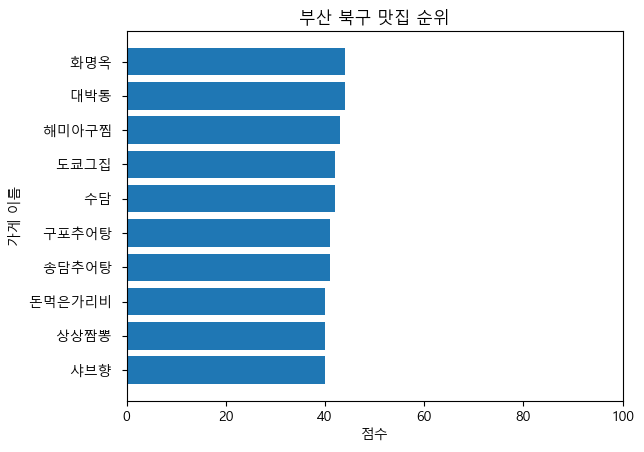

In [6]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from openpyxl import load_workbook
from openpyxl.drawing.image import Image
from openpyxl.utils import get_column_letter
import matplotlib.pyplot as plt
import numpy as np
#from selenium.webdriver.support.select import Select
#from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import pandas as pd
import time
import re
import os
import urllib.request

#맛집 데이터 크롤링
print("=" *50)
print("    전국의 맛집 정보 추출하기 + 이미지 포함")
print("=" *50)

trial = ['','서울', '강원', '경기', '경남', '경북', '광주', '대구', '대전', '부산', '세종', '울산', '인천', '전남', '전북', '제주', '충남', '충북']

busan = ['', '강서구', '금정구', '기장군', '남구', '동구', '동래구', '부산진구', '북구', '사상구', '사하구', '서구', '수영구', '연제구', '영도구', '중구', '해운대구']
category = ['', '배달', '밥집', '카페', '술집', '고깃집', '횟집', '한식', '중식', '일식', '양식', '아시안', '멕시칸', '이탈리안', '프렌치', '뷔페', '브런치', '패스트푸드','분식', '국물요리', '면요리', '해산물']

#지역 입력
for idx in range(len(trial)):
    if idx % 6 == 0:
        print('\n')
    
    if idx == 0:
        print(f" {idx}. 전체", end='\t')
        continue

    print(f" {idx}. {trial[idx]}", end='\t')
print("\n")
trial_idx = int(input('위 지역 중 자료를 수집할 지역의 번호를 적어주세요~'))
print("\n")
print("=" * 50)

#시군구 입력 (부산일 경우만 입력 받을 거임)
busan_idx = 0
if trial_idx == 9: #부산
    for idx in range(len(busan)):
        if idx % 6 == 0:
            print('\n')
    
        if idx == 0:
            print(f" {idx}. 전체", end='\t')
            continue
        print(f" {idx}. {busan[idx]}", end='\t')
    print("\n")
    busan_idx = int(input('위 지역 중 자료를 수집할 지역의 번호를 적어주세요~'))
print("\n")
print("=" * 50)

#카테고리 입력
for idx in range(len(category)):
    if idx % 6 == 0:
        print('\n')
    
    if idx == 0:
        print(f" {idx}. 전체", end='\t')
        continue

    print(f" {idx}. {category[idx]}", end='\t')

print("\n")
category_idx = int(input('위 지역 중 자료를 수집할 지역의 번호를 적어주세요~'))
print("\n")
print("=" * 50)

f_dir = input('결과 파일을 저장할 폴더명만 적어주세요! ')


# 크롬 브라우저 실행
path = "chromedriver.exe"
url = 'https://www.diningcode.com/list.dc?addr=' + trial[trial_idx] + '%20' + busan[busan_idx] +'&keyword=' + category[category_idx]
#driver = webdriver.Chrome(ChromeDriverManager().install())
driver = webdriver.Chrome()
driver.get(url)
time.sleep(4)

# 스크롤 다운
def scroll_down(driver, tag):
    #driver.execute_script("window.scrollTo(0,document.body.scrollHeight);")
    driver.execute_script("arguments[0].scrollBy(0, arguments[0].scrollHeight);", tag)
    time.sleep(1)


list_selector = "#root > div > div"
ac = driver.find_element(By.CSS_SELECTOR, list_selector)
#ti = driver.find_element(By.CLASS_NAME, 'Filter__Info__Title')
arrow = driver.find_element(By.ID, 'arrow')
while True:
    try:
        more = driver.find_element(By.XPATH, '//*[@id="map"]/button[2]')
        more.click()
    except Exception:
        break

time.sleep(2)
arrow.send_keys(Keys.END)

# driver.execute_script("arguments[0].scrollBy(0, document.body.scrollHeight);", ac)
#select_date = Select(driver.find_elements_by_xpath('/html/body/div/div[2]/div[2]/div[3]/form/div/div[1]/div/select'))

html = driver.page_source

soup = BeautifulSoup(html, 'html.parser')
restaurant_list = soup.select('#root > div > div > div > a')
# print(restaurant_list)

imgs = []
ranking = []
names = []
location = []
rest_category =[]
score = []
user_score = []

#이미지 저장용 폴더생성
now = time.localtime()
s = '%04d-%02d-%02d-%02d-%02d-%02d' % (now.tm_year, now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min, now.tm_sec)
os.makedirs(f_dir + '_' +s + '_' + trial[trial_idx] + busan[busan_idx] + category[category_idx])
os.chdir(f_dir + '_' +s + '_' + trial[trial_idx] + busan[busan_idx] + category[category_idx])
img_dir = f_dir + "_" +s + "_images"
os.makedirs(img_dir)
os.chdir(img_dir)

for li in restaurant_list:
    rank = li.select_one('.RHeader > .Info > .InfoHeader > h2').get_text()
    loc = li.select_one('.RHeader > .Info > .InfoHeader > h2 > span').get_text()
    if rank[2] == "0":
        ranking.append(rank[:3])
        names.append(re.sub(loc, "", rank[5:]))
    elif rank[1] == ".":
        ranking.append(rank[:1])
        names.append(re.sub(loc, "", rank[3:]))
    else:
        ranking.append(rank[:2])
        names.append(re.sub(loc, "", rank[4:]))
    location.append(loc)
    
    photo = li.select_one('.RHeader > img')['src']
    imgs.append(rank)
    urllib.request.urlretrieve(photo, str(rank)+'.jpg')
    time.sleep(1)

    try :
        rest_cate = li.select_one('.Category > strong').get_text()
        rest_cate2 = li.select_one('.Category > span').get_text()
        rest_category.append(rest_cate + "_" + rest_cate2)
    except Exception :
        rest_cate1 = re.sub(r"\s", "_", rest_cate)
        rest_category.append(rest_cate1)

    sc = li.select_one('.Rate > .Score > span').get_text()
    usc = li.select_one('.UserScore').get_text()[:3]
    #usc2 = usc.replace('(', '_')
    #usc3 = re.sub(r"\s", "", usc2)
    score.append(sc)
    user_score.append(usc)
    
os.chdir('../')
score1 = map(int, score)
yummy = pd.DataFrame()
yummy['순위'] = pd.Series(ranking)
yummy['이름'] = pd.Series(names)
yummy['위치'] = pd.Series(location)
yummy['카테고리'] = pd.Series(rest_category)
yummy['점수'] = pd.Series(score1)
yummy['평점'] = pd.Series(user_score)


#csv 파일로 저장
f_name = trial[trial_idx] + busan[busan_idx] + '_' +category[category_idx] + '_' + s
yummy.to_csv(f'{f_name}.csv', index=False, encoding='cp949')

#xlsx 파일로 저장
yummy.to_excel(f'{f_name}.xlsx', index=False)

wb = load_workbook(f'{f_name}.xlsx')
ws = wb.active
ws['G1'] = '이미지'
for index, image_path in enumerate(imgs,2):
    img = Image(img_dir + '\\' + image_path +'.jpg')
    img.height = 100
    img.width = 100
    ws.column_dimensions['G'].width = 12
    ws.row_dimensions[index].height = 75

    ws.add_image(img, 'G'+ str(index))
    #ws[f'C{index}'] = img

wb.save(f'{f_name}.xlsx')

os.chdir('../')

yummy_top10 = yummy.head(10)
yummy_top10 = yummy_top10.sort_values(by=['점수'], ascending=[True])

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.barh(yummy_top10['이름'], yummy_top10['점수'])
plt.title(f"{trial[trial_idx]} {busan[busan_idx]} 맛집 순위")
plt.xlabel("점수")
plt.ylabel("가게 이름")
plt.xlim(0,100)
plt.show()

In [7]:
import os
print(os.getcwd())
#os.chdir('../')
print(os.getcwd())
#print(os.path.dirname(os.path.realpath()) )

c:\Users\user\Documents\Python Scripts\python
c:\Users\user\Documents\Python Scripts\python
